# Problem 1: Image Warping

In [1]:
# allow Jupyter to "hot reload" the Python modules I wrote, to avoid restarting the kernel after every change
%load_ext autoreload
%autoreload 2

## Setup: Loading the Image

In [2]:
from util import ops

In [4]:
original_bball_court = ops.load_image(
    "../basketball-court.ppm",
    return_array=True,
    return_grayscale=False,
)

Dimensions of ../basketball-court.ppm: 366 x 488 x 3


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

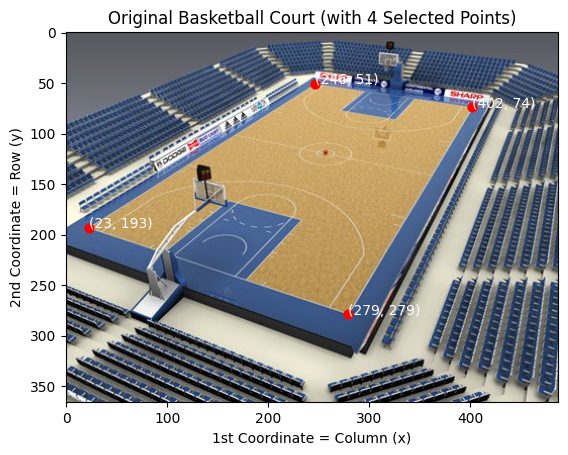

In [10]:
plt.imshow(original_bball_court)

x = [23, 246, 402, 279]
y = [193, 51, 74, 279]

plt.scatter(x=x, y=y, c="r", s=40)
for x_coord, y_coord in zip(x, y):
    plt.text(x_coord, y_coord, s=f"({x_coord}, {y_coord})", c="w")

plt.xlabel("1st Coordinate = Column (x)")
plt.ylabel("2nd Coordinate = Row (y)")
plt.title("Original Basketball Court (with 4 Selected Points)")
plt.show()

## Part 1: Homography Estimation

- **Inputs**: pixel feature locations
- **Algorithm**: Normalized DLT 

### Let's take a guess at what coordinates to use for the corresponding points in the output image

In [14]:
court_length_along_y = (x[1] - x[0]) # 2
court_length_along_x = abs(y[0] - y[-1]) # 2

In [16]:
court_length_along_y, court_length_along_x  # (height, width of just the court)

(111, 43)

Here, I will include guesses for what the coordinates of the 4 pixel points chosen in the image will be in the output, as well as a few other dimensions:

In [19]:
destination_img_total_height = 940
destination_img_total_width = 500

# dimensions of the image outside the court
vertical_empty_margin = 45  # total guess, this will be on each of the 2 sides
vertical_margin_bleachers = 325  # total guess, this will be on each of the 2 sides

horizontal_empty_margin = 25  # total guess, this will be on each of the 2 sides
horizontal_margin_bleachers = 200  # total guess, this will be on each of the 2 sides

### guess-timating the destination coordinates of the selected points
destination_top_left = (
    vertical_empty_margin + vertical_margin_bleachers,
    horizontal_empty_margin + horizontal_margin_bleachers,
)
destination_bottom_left = (
    vertical_empty_margin + vertical_margin_bleachers + court_length_along_y,
    horizontal_empty_margin + horizontal_margin_bleachers,
)
destination_top_right = (
    vertical_empty_margin + vertical_margin_bleachers,
    horizontal_empty_margin + horizontal_margin_bleachers + court_length_along_x,
)
destination_bottom_right = (
    vertical_empty_margin + vertical_margin_bleachers + court_length_along_y,
    horizontal_empty_margin + horizontal_margin_bleachers + court_length_along_x,
)

### Implementing Normalized DLT

The code is based on pseudocode I encountered while conversing with ChatGPT: https:#chat.openai.com/share/3c9cf6ed-4035-42f4-b217-359a1f976474

In [20]:
def normalize_points(points):
    # Compute the centroid of the points
    centroid = compute_centroid(points)

    # Compute the average distance from the centroid
    average_distance = compute_average_distance(centroid, points)

    # Scale the points by the reciprocal of the average distance
    normalized_points = [(point - centroid) / average_distance for point in points]

    return normalized_points, centroid, average_distance


def denormalize_homography_matrix(H, centroid1, centroid2, scale1, scale2):
    # Denormalize the homography matrix based on the centroids and scales
    T1 = [
        [1 / scale1, 0, -centroid1[0] / scale1],
        [0, 1 / scale1, -centroid1[1] / scale1],
        [0, 0, 1],
    ]

    T2 = [[scale2, 0, centroid2[0]], [0, scale2, centroid2[1]], [0, 0, 1]]

    denormalized_h = inverse(T2) * H * T1

    return denormalized_h


def compute_normalized_DFT(sourcePoints, destinationPoints, num_points):
    # Normalize source and destination points
    normalized_source_points, centroid_source, scale_source = normalize_points(
        sourcePoints
    )
    (
        normalized_destination_points,
        centroid_destination,
        scale_destination,
    ) = normalize_points(destinationPoints)

    # Construct the homogeneous system of equations using normalized points
    normalized_A = []
    for i in range(num_points - 1):
        x, y = normalized_source_points[i]
        x_prime, y_prime = normalized_destination_points[i]

        normalized_A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        normalized_A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])

    # Use a linear solver to solve the system of equations Ax = 0
    normalized_X = solve_homogeneous_system(normalized_A)  # TODO[Zain]: use np.linalg.svd?

    # Reshape the solution into a 3x3 normalized homography matrix
    normalized_H = [
        [normalized_X[0], normalized_X[1], normalized_X[2]],
        [normalized_X[3], normalized_X[4], normalized_X[5]],
        [normalized_X[6], normalized_X[7], normalized_X[8]],
    ]

    # Denormalize the homography matrix
    denormalized_H = denormalize_homography_matrix(
        normalized_H,
        centroid_source,
        centroid_destination,
        scale_source,
        scale_destination,
    )

    return denormalized_H